<a href="https://colab.research.google.com/github/rajdeepd/tensorflow_2.0_book_code/blob/master/ch09/post_training_quant_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post-training dynamic range quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/rajdeepd/tensorflow_2.0_book_code/blob/master/ch09/post_training_quant_fashion_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/rajdeepd/tensorflow_2.0_book_code/blob/master/ch09/post_training_quant_fashion_mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/)  converts weights to 8 bit floating point as it converts tensorflow [graphdefs](https://haosdent.gitbooks.io/tensorflow-document/content/resources/data_versions.html) to TensorFlow Lite flat buffer format. Dynamic range quantization (also called post training quantizaton) is able to achive 4x reduction in model size. TFLit also supports using quantized kernels for faster implementation and mixing floating point kernels with quantized kernels in the same graph.
Activations are stored in floating port, are quantized to 8 bits of precision and then are de-quantized to floating point precision after processing.

In this technique the weights are quantized post training. Model weights are not retrained to compensate for quantization so make sure you test the model for accuracy.


## Build an Fashion MNIST model

### Setup

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

### Train a TensorFlow model

In [2]:
# Load Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

1875/1875 [==============================] - 23s 12ms/step - loss: 0.5152 - accuracy: 0.8193 - val_loss: 0.4285 - val_accuracy: 0.8513


For the example, since you trained the model for just a single epoch, so it only trains to ~81% to 83% accuracy.


### Convert to a TensorFlow Lite model

Using the Python [TFLiteConverter](https://www.tensorflow.org/lite/convert/python_api), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmptdmqwtpq/assets


Write it out to a tflite file:

In [4]:
tflite_models_dir = pathlib.Path("/tmp/fashion_mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [5]:
tflite_model_file = tflite_models_dir/"fashion_mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84500

To quantize the model on export, set the `optimizations` flag to optimize for size:

In [6]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"fashion_mnist_model.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpzqj403v1/assets


INFO:tensorflow:Assets written to: /tmp/tmpzqj403v1/assets


23904

Note how the resulting file, is approximately `1/4` the size.

In [7]:
!ls -lh {tflite_models_dir}

total 24K
-rw-r--r-- 1 root root 24K Sep 19 04:10 fashion_mnist_model.tflite


## Run the TFLite models

Run the TensorFlow Lite model using the Python TensorFlow Lite
Interpreter.


### Load the model into an interpreter

In [8]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [9]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

### Test the model on one image

In [27]:
test_image = np.expand_dims(test_images[1], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

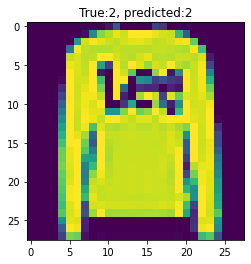

In [28]:
import matplotlib.pylab as plt

plt.imshow(test_images[1])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[1]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [38]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [13]:
print(evaluate_model(interpreter))

0.8499


Repeat the evaluation on the dynamic range quantized model to obtain:


In [15]:
print(evaluate_model(interpreter_quant))

0.8499


In this example, the compressed model has no difference at all in the accuracy.